In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import wget
from zipfile import ZipFile
import string
import preprocessor.api as p
import warnings
warnings.filterwarnings("ignore")
import re
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter
import json
import time
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import wordninja
from nltk.stem.snowball import SnowballStemmer

import shutil

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

# Data loading

Uploading the training and test datasets

In [ ]:
#url = 'http://alt.qcri.org/semeval2016/task6/data/uploads/stancedataset.zip'
#filename = wget.download(url)
#with ZipFile(filename, 'r') as zipObj:
#    zipObj.extractall()

In [ ]:
def upload_data (path_train, path_test):
    #train data
    dt = pd.read_csv(path_train, engine='python' )
    raw_train, raw_val = train_test_split(dt, test_size=0.10, random_state=1)#generating the validation data   
    raw_train.to_csv('raw_train.csv', index=False) #saving all train data
    raw_val.to_csv('raw_val.csv', index=False) #saving 10% val data
    #test data
    dt2 = pd.read_csv(path_test, engine='python' )
    raw_test = dt2[dt2['Target']!= 'Donald Trump'] #excluding trump target
    raw_test.to_csv('raw_test.csv', index=False) #saving all test data
    return raw_train, raw_val, raw_test

In [ ]:
path_train = 'StanceDataset/train.csv'
path_test = 'StanceDataset/test.csv'

raw_train, raw_val, raw_test = upload_data (path_train, path_test)

Creating the training, validation and test datasets for each target

In [ ]:
tar = {'Legalization of Abortion':'abortion',
     'Feminist Movement': 'feminism',
     'Hillary Clinton': 'hillary',
     'Climate Change is a Real Concern': 'climate',
     'Atheism': 'atheism'     
    }

#train, validation and test datasets, filtered by targets, overall 3 datasets * 5 targets = 15 files
for key in tar.keys():
        filt_tr = raw_train[raw_train['Target']=='{}'.format(key)]           
        filt_tr.to_csv('raw_train' +'_'+ tar.get('{}'.format(key))+'.csv',index=False)
        
        filt_val = raw_val[raw_val['Target']=='{}'.format(key)]           
        filt_val.to_csv('raw_val' +'_'+ tar.get('{}'.format(key))+'.csv',index=False)
        
        filt_tst = raw_test[raw_test['Target']=='{}'.format(key)]           
        filt_tst.to_csv('raw_test' +'_'+ tar.get('{}'.format(key))+'.csv',index=False)

# Data Exloration

In [46]:
dt = pd.read_csv(path_train, engine = 'python')
dt.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [48]:
#counting the number of words in each sentence
dt['word_number'] = dt['Tweet'].apply(lambda x: len(x.split(' ')))
dt.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment,word_number
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,17
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,16
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,16
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,19
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,9


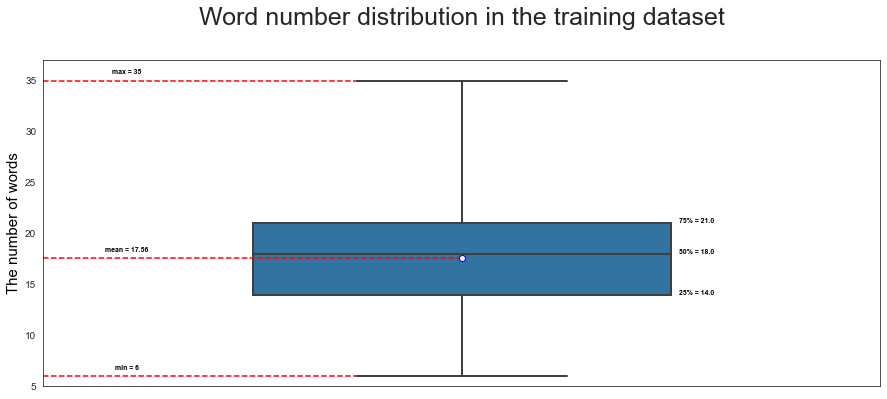

In [49]:
#Word number distribution in the training dataset
plt.figure(figsize=(15,6))
sns.set_style('white')

ax = sns.boxplot(data=dt,  y='word_number', width=.5, showfliers=False, whis=[0,100], showmeans=True,
           meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"blue"}, linewidth=2)
plt.ylabel("The number of words", fontsize= 15, color = 'black')

plt.title('Word number distribution in the training dataset', fontsize = 25, pad = 35)


mean = round(dt['word_number'].mean(), 2)
minimum = min(dt['word_number'])
maximum = max(dt['word_number'])
median = dt['word_number'].median()
q1 = dt['word_number'].quantile(.25)
q3 = dt['word_number'].quantile(.75)



reference = [minimum, mean, maximum]

left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=0.005, color='r', linestyles='--')

plt.ylim(5,37)

ax.text(-0.4, mean+0.6, 'mean = ' + str(mean),
       horizontalalignment='center',size='x-small',color='black',weight='semibold')

ax.text(-0.4, minimum+0.6, 'min = ' + str(minimum),
       horizontalalignment='center',size='x-small',color='black',weight='semibold')

ax.text(-0.4, maximum+0.6, 'max = ' + str(maximum),
       horizontalalignment='center',size='x-small',color='black',weight='semibold')


ax.text(0.28, q1, '25% = ' + str(q1),
       horizontalalignment='center',size='x-small',color='black',weight='semibold')

ax.text(0.28, median, '50% = ' + str(median),
       horizontalalignment='center',size='x-small',color='black',weight='semibold')

ax.text(0.28, q3, '75% = ' + str(q3),
       horizontalalignment='center',size='x-small',color='black',weight='semibold')

plt.show()

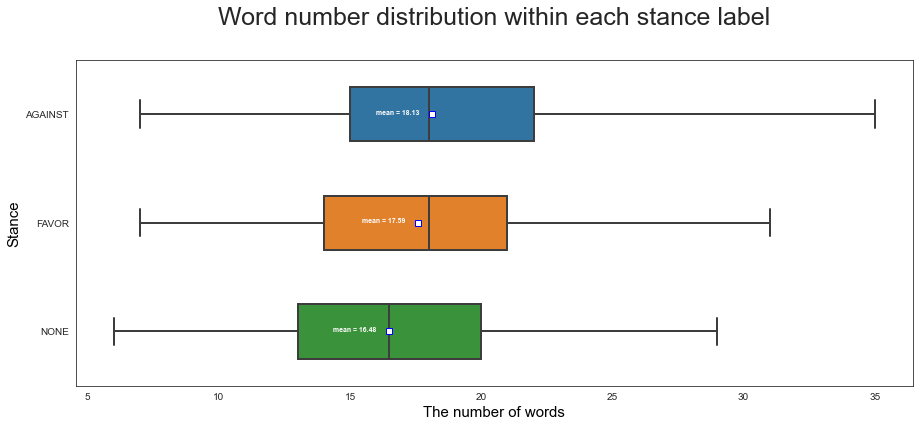

In [50]:
plt.figure(figsize=(15,6))


sns.set_style("white")
ax = sns.boxplot(data=dt, y='Stance', x='word_number', width=.5, showfliers=False, whis=[0,100], showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, linewidth=2)

plt.xlabel("The number of words", fontsize= 15, color = 'black')
plt.ylabel("Stance", fontsize= 15, color = 'black')
plt.title('Word number distribution within each stance label', fontsize = 25, pad = 35)



mean = round(dt.groupby(['Stance'])['word_number'].mean(), 2)

for xtick in ax.get_yticks():
    ax.text(mean[xtick] - 1.3,xtick,'mean = '+str(mean[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.show()

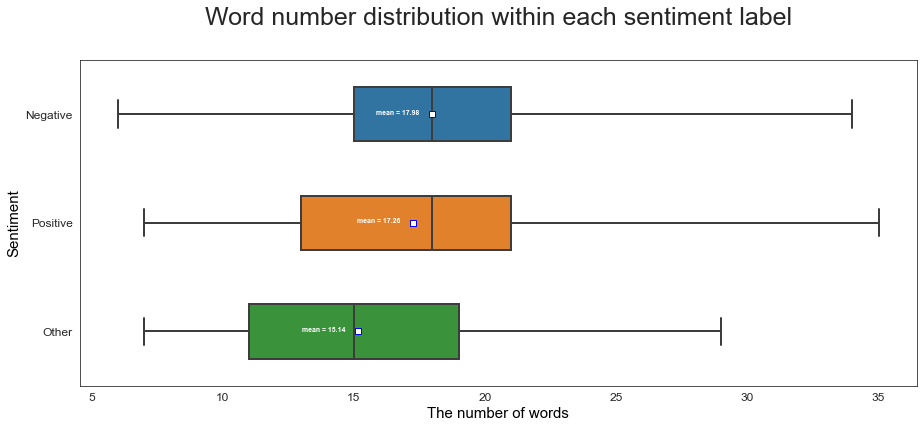

In [51]:
plt.figure(figsize=(15,6))
ax = sns.boxplot(data=dt, y='Sentiment', x='word_number', 
                 width=.5, showfliers=True, whis=[0,100],showmeans=True,
                 meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, linewidth=2)
plt.xlabel("The number of words", fontsize= 15, color = 'black')
plt.xticks(fontsize = 12)
plt.yticks([0, 1, 2], ['Negative', 'Positive', 'Other'], fontsize = 12)
plt.ylabel("Sentiment", fontsize= 15, color = 'black')
plt.title('Word number distribution within each sentiment label', fontsize = 25, pad = 35)

mean = round(dt.groupby(['Sentiment'])['word_number'].mean().sort_values(ascending=False), 2)

for xtick in ax.get_yticks():
    ax.text(mean[xtick] - 1.3, xtick,'mean = '+str(mean[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.show()

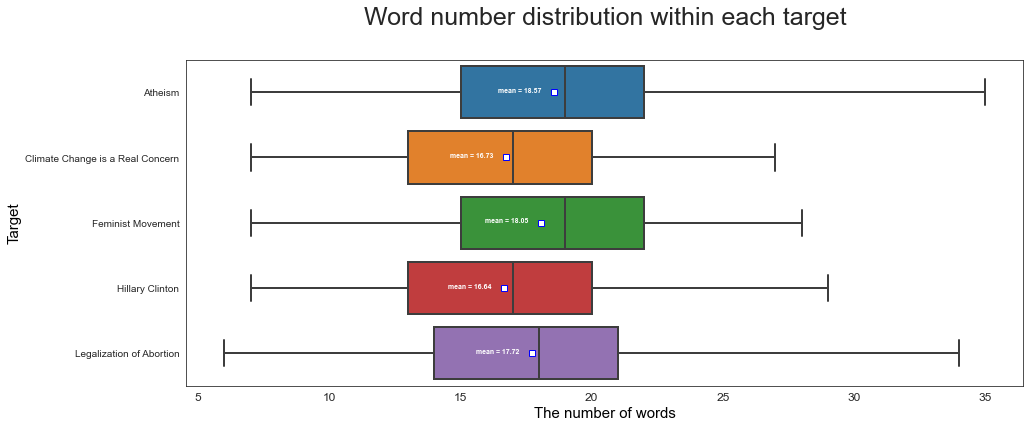

In [52]:
plt.figure(figsize=(15,6))
ax = sns.boxplot(data=dt, y='Target', x='word_number',
                 order = ['Atheism', 'Climate Change is a Real Concern','Feminist Movement','Hillary Clinton',
                                                                'Legalization of Abortion'],
                 width=.8, showfliers=True, whis=[0,100],showmeans=True,
                 meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, linewidth=2)
plt.xlabel("The number of words", fontsize= 15, color = 'black')
plt.xticks(fontsize = 12)

plt.ylabel("Target", fontsize= 15, color = 'black')
plt.title('Word number distribution within each target', fontsize = 25, pad = 35)

mean = round(dt.groupby(['Target'])['word_number'].mean(), 2)

for xtick in ax.get_yticks():
    ax.text(mean[xtick] - 1.3, xtick,'mean = '+str(mean[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
    
plt.show()

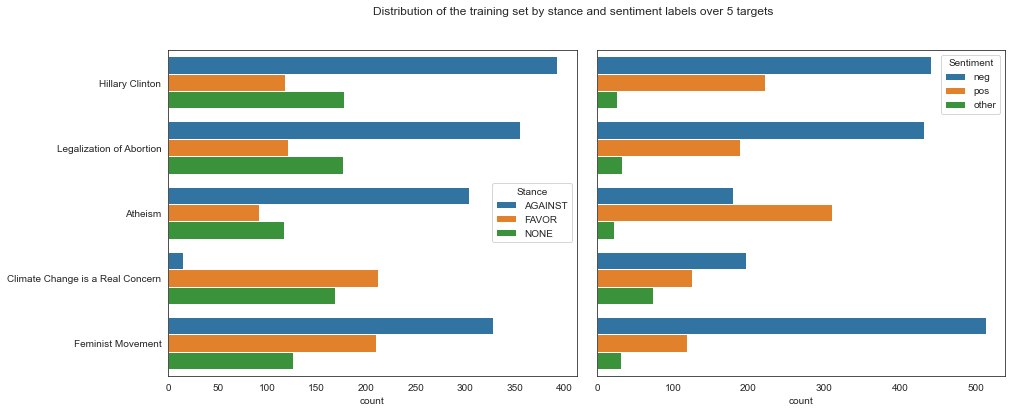

In [53]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 6))
sns.countplot(y="Target", hue = 'Stance', data=dt, ax=axes[0])

sns.countplot(y="Target", hue="Sentiment", data=dt, ax=axes[1])

#plt.title('Word number distribution within each target', fontsize = 25, pad = 35)
f.suptitle('Distribution of the training set by stance and sentiment labels over 5 targets') 
axes[0].set_ylabel('')
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0.05, hspace=0)

In [54]:
#Creating Normalization Dictionary

with open("noslang_data.json", "r") as f:
    data1 = json.load(f)

data2 = {}
with open("emnlp_dict.txt","r") as f:
    lines = f.readlines()
    for line in lines:
        row = line.split('\t')
        data2[row[0]] = row[1].rstrip()

normalization_dict = {**data1,**data2}

In [55]:
def preproccess(doc):
    
    normalized_tokens = []

    tokens = doc.split()
    
    for word in tokens:
        if word in normalization_dict.keys():
            normalized_tokens.append(normalization_dict[word.lower()])
        elif word.startswith('#SemST'):
            normalized_tokens.append(re.sub('#SemST', '', word))
        elif word.startswith('#'):
            normalized_tokens.extend(wordninja.split(word))
        else:
            normalized_tokens.append(word)

    return " ".join(normalized_tokens)

In [56]:
def clean_doc(doc):
    tokens = doc.split()
    tokens = [word.lower() for word in tokens]
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return " ".join(tokens)

In [57]:
#preprocessing the dataset
dt['cleaned'] = dt['Tweet'].apply(preproccess)

In [58]:
#cleaning the text
dt['cleaned'] = dt['cleaned'].apply(clean_doc)

In [59]:
pos = dt[dt['Sentiment'] == 'pos']['cleaned']
neg = dt[dt['Sentiment'] == 'neg']['cleaned']

pos1 = dt[dt['Stance'] == 'FAVOR']['cleaned']
neg1 = dt[dt['Stance'] == 'AGAINST']['cleaned']

In [60]:
#the function to filter words with given occurrence
def occur(doc):
    vocab = Counter()
    for sent in doc:
        vocab.update(sent.split())
    tokens = [k for k,c in vocab.items() if c >= 1]
    return ' '.join(str(i) for i in tokens)

In [61]:
tokens_pos = occur(pos)
tokens_neg = occur(neg)
tokens_pos1 = occur(pos1)
tokens_neg1 = occur(neg1)

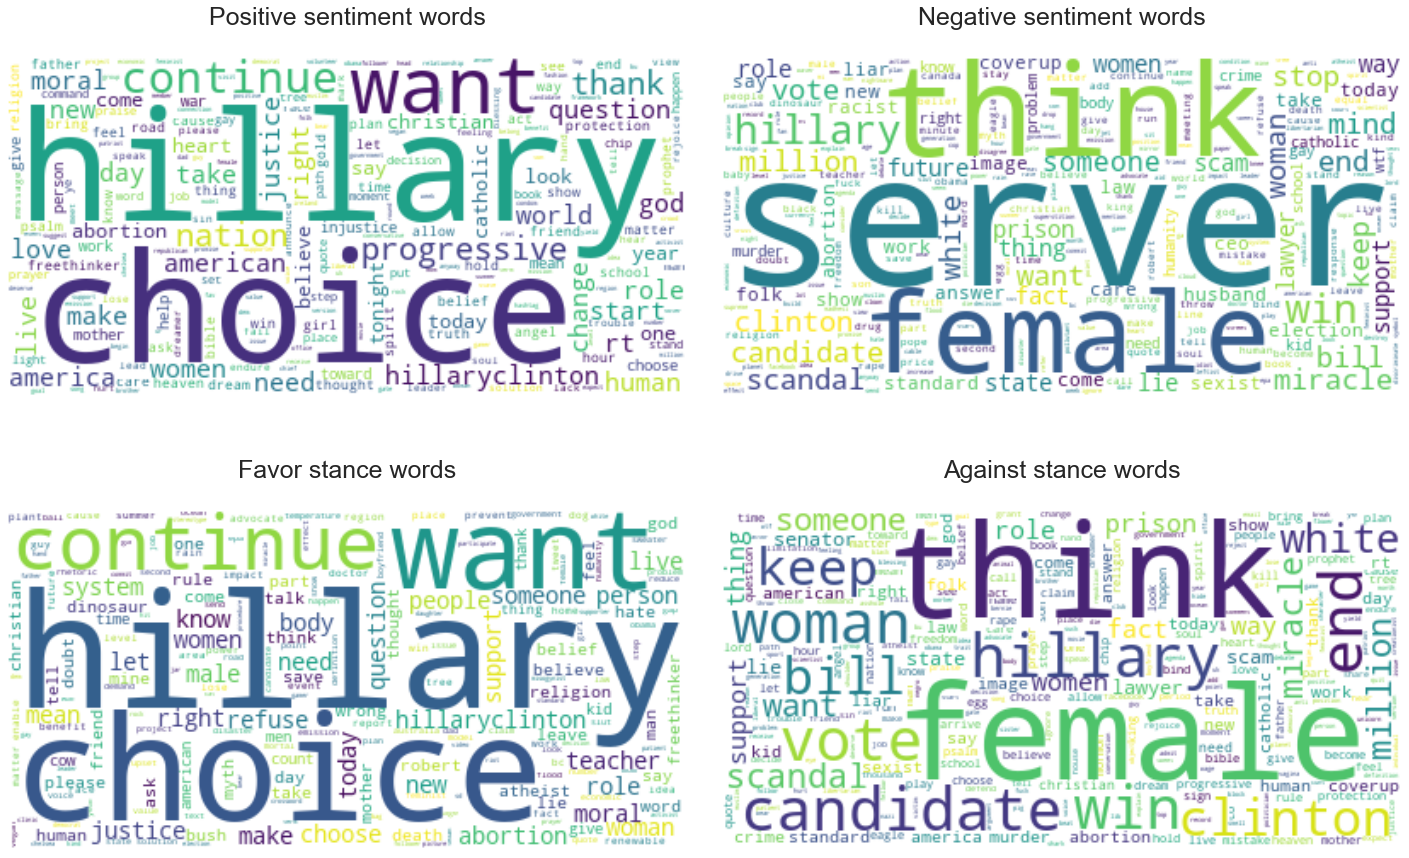

In [62]:
wordcloud = WordCloud(background_color="white",max_words=len(tokens_pos)).generate(tokens_pos)
wordcloud1 = WordCloud(background_color="white",max_words=len(tokens_neg)).generate(tokens_neg)
wordcloud2 = WordCloud(background_color="white",max_words=len(tokens_pos1)).generate(tokens_pos1)
wordcloud3 = WordCloud(background_color="white",max_words=len(tokens_neg1)).generate(tokens_neg1)

fig, ax = plt.subplots(2, 2, figsize=(25,25))


ax[0,0].imshow(wordcloud, interpolation='bilinear')
ax[0,1].imshow(wordcloud1, interpolation='bilinear')
ax[1,0].imshow(wordcloud2, interpolation='bilinear')
ax[1,1].imshow(wordcloud3, interpolation='bilinear')

ax[0,0].axis("off")
ax[0,0].set_title('Positive sentiment words', fontsize="25",  y=1.08)
ax[0,1].axis("off")
ax[0,1].set_title('Negative sentiment words', fontsize="25",  y=1.08)

ax[1,0].axis("off")
ax[1,0].set_title('Favor stance words', fontsize="25",  y=1.08)

ax[1,1].axis("off")
ax[1,1].set_title('Against stance words', fontsize="25",  y=1.08)

plt.subplots_adjust(wspace=0.05, hspace=-0.5)
plt.show()

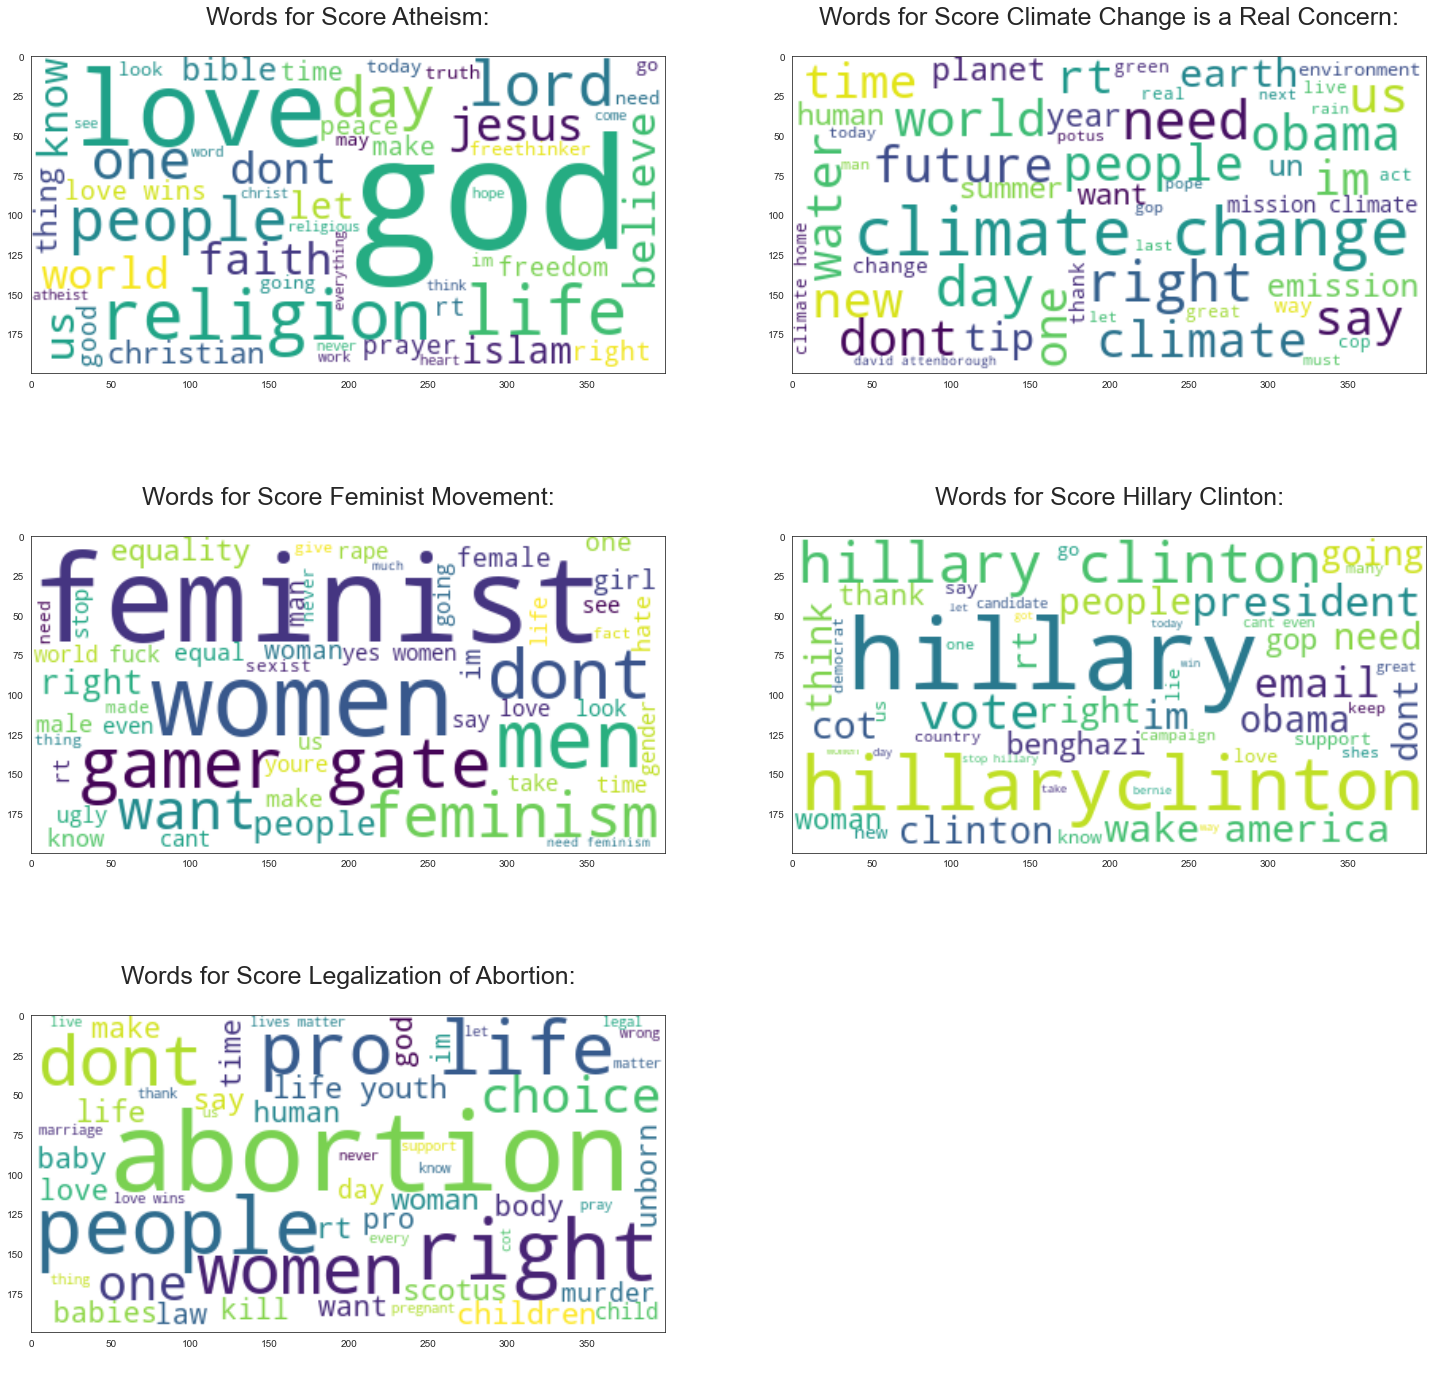

In [63]:
targets = ['Atheism','Climate Change is a Real Concern','Feminist Movement',
           'Hillary Clinton','Legalization of Abortion']
#alternatively, we also exlored the most associated words regarding each review score
fig, ax = plt.subplots(3, 2, figsize=(25,25))
for c, i in enumerate(targets):
    txt = dt[dt["Target"]==i]["cleaned"] 
    collapsed_txt = txt.str.cat(sep=' ')
    wordcloud = WordCloud(background_color="white",max_words=50).generate(collapsed_txt)
    
    if c % 2 !=0:
        ax[int((c/2)-0.5),1].imshow(wordcloud, interpolation='bilinear')
        ax[int((c/2)-0.5),1].set_title("Words for Score {}:".format(i), fontsize="25",  y=1.08)
    else:
        ax[int(c/2),0].imshow(wordcloud, interpolation='bilinear')
        ax[int(c/2),0].set_title("Words for Score {}:".format(i), fontsize="25",  y=1.08)
    
plt.axis("off")
plt.show()

# Class distribution balancing

Class distribution balancing for stance labels

In [64]:
dt = pd.read_csv(path_train, engine = 'python')
dt2 = pd.read_csv(path_train, engine = 'python')


In [65]:
dt2.loc[(dt2['Target'] != 'Climate Change is a Real Concern') & (dt2['Stance']!='AGAINST'), 'Stance'] = 'Non-Against' 
dt2.loc[(dt2['Target'] != 'Atheism') & (dt2['Sentiment']!='neg'), 'Sentiment'] = 'non-neg'
dt2.loc[(dt2['Target'] == 'Climate Change is a Real Concern') & (dt2['Stance']!='FAVOR'), 'Stance'] = 'Non-Favor'
dt2.loc[(dt2['Target'] == 'Atheism') & (dt2['Sentiment']!='pos'), 'Sentiment'] = 'non-pos' 

In [66]:
dt3 = dt2[dt2['Target']!='Climate Change is a Real Concern']
dt4 = dt[dt['Target']!='Climate Change is a Real Concern']
#datasets for "climate" target
dt5 = dt2[dt2['Target']=='Climate Change is a Real Concern']
dt6 = dt[dt['Target']=='Climate Change is a Real Concern']

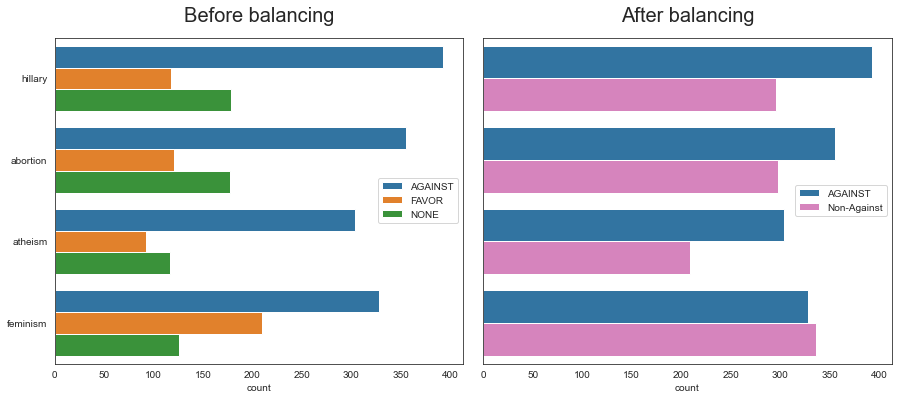

In [67]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 6))
sns.countplot(y="Target", hue = 'Stance', data=dt4, ax=axes[0], palette=["C0", "C1", "C2"])
sns.countplot(y="Target", hue = 'Stance', data=dt3, ax=axes[1], palette=["C0", "C6"])

#sns.countplot(y="Target", hue="Sentiment", data=dt2, ax=axes[1])

#plt.title('Word number distribution within each target', fontsize = 25, pad = 35)
#f.suptitle('Distribution of the training set by stance labels') 
axes[0].set_ylabel('')
axes[0].legend(fontsize=10, loc=5)
axes[0].set_title("Before balancing", fontsize="20",  y=1.03)
axes[1].set_title("After balancing", fontsize="20",  y=1.03)
axes[1].set_ylabel('')
axes[1].legend(fontsize=10, loc=5)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.yticks([0,1,2,3], ['hillary', 'abortion', 'atheism', 'feminism'], fontsize = 12)
plt.show()

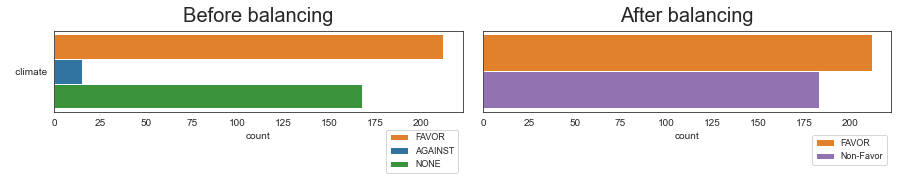

In [68]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 1.5))
sns.countplot(y="Target", hue = 'Stance', data=dt6, ax=axes[0],  palette=["C1", "C0", "C2"])
sns.countplot(y="Target", hue = 'Stance', data=dt5, ax=axes[1], palette=["C1", "C4"])

#sns.countplot(y="Target", hue="Sentiment", data=dt2, ax=axes[1])

#plt.title('Word number distribution within each target', fontsize = 25, pad = 35)

axes[0].set_ylabel('')
axes[0].legend(fontsize=9, loc=4, bbox_to_anchor=(1, -0.8))
axes[1].set_ylabel('')
axes[1].legend(fontsize=9, loc=4, bbox_to_anchor=(1, -0.7))
axes[0].set_title("Before balancing", fontsize="20",  y=1.03)
axes[1].set_title("After balancing", fontsize="20",  y=1.03)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.yticks([0], ['   climate'], fontsize = 12)
plt.show()

In [69]:
#before balancing
dt.groupby(['Target', 'Stance'])['Tweet'].count()


Target                            Stance 
Atheism                           AGAINST    304
                                  FAVOR       92
                                  NONE       117
Climate Change is a Real Concern  AGAINST     15
                                  FAVOR      212
                                  NONE       168
Feminist Movement                 AGAINST    328
                                  FAVOR      210
                                  NONE       126
Hillary Clinton                   AGAINST    393
                                  FAVOR      118
                                  NONE       178
Legalization of Abortion          AGAINST    355
                                  FAVOR      121
                                  NONE       177
Name: Tweet, dtype: int64

In [70]:
#after balancing
dt2.groupby(['Target', 'Stance'])['Tweet'].count()


Target                            Stance     
Atheism                           AGAINST        304
                                  Non-Against    209
Climate Change is a Real Concern  FAVOR          212
                                  Non-Favor      183
Feminist Movement                 AGAINST        328
                                  Non-Against    336
Hillary Clinton                   AGAINST        393
                                  Non-Against    296
Legalization of Abortion          AGAINST        355
                                  Non-Against    298
Name: Tweet, dtype: int64

Class distribution balancing for sentiment labels

In [71]:
dt7 = dt2[dt2['Target']!='Atheism']
dt8 = dt[dt['Target']!='Atheism']
dt9 = dt2[dt2['Target']=='Atheism']
dt10 = dt[dt['Target']=='Atheism']

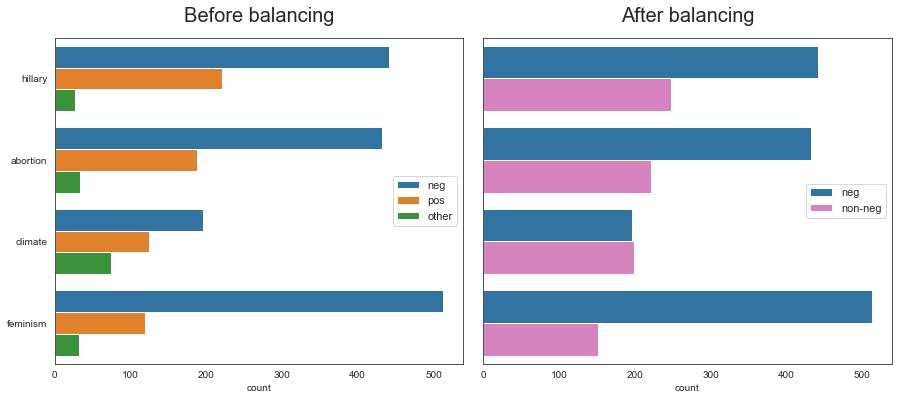

In [72]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 6))
sns.countplot(y="Target", hue = 'Sentiment', data=dt8, ax=axes[0],  palette=["C0", "C1", "C2"])
sns.countplot(y="Target", hue = 'Sentiment', data=dt7, ax=axes[1], palette=["C0", "C6"])

#sns.countplot(y="Target", hue="Sentiment", data=dt2, ax=axes[1])

#plt.title('Word number distribution within each target', fontsize = 25, pad = 35)

axes[0].set_ylabel('')
axes[0].legend(fontsize=11, loc=5)
axes[1].set_ylabel('')
axes[1].legend(fontsize=11, loc=5)
axes[0].set_title("Before balancing", fontsize="20",  y=1.03)
axes[1].set_title("After balancing", fontsize="20",  y=1.03)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.yticks([0,1,2,3], ['hillary', 'abortion', 'climate', 'feminism'], fontsize = 12)
plt.show()

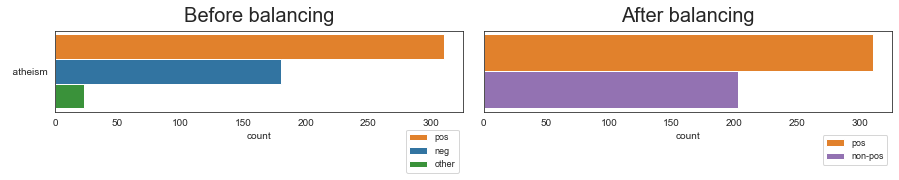

In [73]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 1.5))
sns.countplot(y="Target", hue = 'Sentiment', data=dt10, ax=axes[0],  palette=["C1", "C0", "C2"])
sns.countplot(y="Target", hue = 'Sentiment', data=dt9, ax=axes[1], palette=["C1", "C4"])

#sns.countplot(y="Target", hue="Sentiment", data=dt2, ax=axes[1])

#plt.title('Word number distribution within each target', fontsize = 25, pad = 35)

axes[0].set_ylabel('')
axes[0].legend(fontsize=9, loc=4, bbox_to_anchor=(1, -0.8))
axes[1].set_ylabel('')
axes[1].legend(fontsize=9, loc=4, bbox_to_anchor=(1, -0.7))
axes[0].set_title("Before balancing", fontsize="20",  y=1.03)
axes[1].set_title("After balancing", fontsize="20",  y=1.03)
plt.subplots_adjust(wspace=0.05, hspace=0)

plt.yticks([0], ['  atheism'], fontsize = 12)
plt.show()


In [74]:
dt.groupby(['Target', 'Sentiment'])['Tweet'].count()


Target                            Sentiment
Atheism                           neg          180
                                  other         23
                                  pos          310
Climate Change is a Real Concern  neg          196
                                  other         74
                                  pos          125
Feminist Movement                 neg          513
                                  other         32
                                  pos          119
Hillary Clinton                   neg          441
                                  other         27
                                  pos          221
Legalization of Abortion          neg          432
                                  other         33
                                  pos          188
Name: Tweet, dtype: int64

In [75]:
dt2.groupby(['Target', 'Sentiment'])['Tweet'].count()



Target                            Sentiment
Atheism                           non-pos      203
                                  pos          310
Climate Change is a Real Concern  neg          196
                                  non-neg      199
Feminist Movement                 neg          513
                                  non-neg      151
Hillary Clinton                   neg          441
                                  non-neg      248
Legalization of Abortion          neg          432
                                  non-neg      221
Name: Tweet, dtype: int64

# Model development

Building lexicon dictionary

In [ ]:
lexs = {'atheism': ('Lexicon_Atheism', 1),
        'climate': ('Lexicon_Climate', 2),
       'feminism': ('Lexicon_Feminism',3),
       'hillary': ('Lexicon_Hillary', 4),
       'abortion': ('Lexicon_Abortion', 5)}

In [ ]:
def upload_lex(filename):
    filename = [filename]
    lexicon = pd.read_csv(filename[0],usecols=[lexs.get(tar)[1]], encoding='ISO-8859-1')
    lexicon2 = pd.read_csv(filename[0],usecols=[0], encoding='ISO-8859-1')
    stance_lexicon = lexicon[lexs.get(tar)[0]].values.tolist()
    sentiment_lexicon = lexicon2['Lexicon_Sentiment'].values.tolist()
    return stance_lexicon, sentiment_lexicon

In [ ]:
def process_OOV(x_pad,lexicon_pad, stance_lexicon, sentiment_lexicon):
    stemmer = SnowballStemmer("english")
    for i in range(len(x_pad)):
        for j in range(len(x_pad[i])):
            if stemmer.stem(x_pad[i][j]) not in stance_lexicon and stemmer.stem(x_pad[i][j]) not in \
                sentiment_lexicon and x_pad[i][j] not in sentiment_lexicon and x_pad[i][j] \
                not in stance_lexicon:
                
                lexicon_pad[i][j] = 0
            else:
                lexicon_pad[i][j] = 1
    
    return lexicon_pad

In [ ]:
def create_lex (lex_file, xtrain, val, test):
    stance_lexicon, sentiment_lexicon = upload_lex(lex_file)
   
    x_train_pad = np.array([xi.split()[:MAX_LEN]+['OOV']*(MAX_LEN-len(xi.split())) for xi in xtrain.iloc[:,0]])
    val_pad = np.array([xi.split()[:MAX_LEN]+['OOV']*(MAX_LEN-len(xi.split())) for xi in val.iloc[:,0]])
    test_pad = np.array([xi.split()[:MAX_LEN]+['OOV']*(MAX_LEN-len(xi.split())) for xi in test.iloc[:,0]])
    
    lexicon_train = np.zeros_like(x_train_pad,dtype=int)
    lexicon_train = process_OOV(x_train_pad,lexicon_train, stance_lexicon, sentiment_lexicon)
    lexicon_val = np.zeros_like(val_pad,dtype=int)
    lexicon_val = process_OOV(val_pad,lexicon_val, stance_lexicon, sentiment_lexicon) 
    lexicon_test = np.zeros_like(test_pad,dtype=int)
    lexicon_test = process_OOV(test_pad,lexicon_test, stance_lexicon, sentiment_lexicon)
    
    return lexicon_train,  lexicon_val,  lexicon_test

Load and Transform corresponding dataset

In [ ]:
# Data Loading

def Load_Transform_Data(filename):
    #Loading data
    filename = [filename]
    concat_text = pd.DataFrame()
    raw_text = pd.read_csv(filename[0],usecols=[0], encoding='ISO-8859-1', engine='python')
    raw_label = pd.read_csv(filename[0],usecols=[2], encoding='ISO-8859-1', engine='python')
    raw_label2 = pd.read_csv(filename[0],usecols=[4], encoding='ISO-8859-1', engine='python')
    raw_target = pd.read_csv(filename[0],usecols=[1], encoding='ISO-8859-1', engine='python')
    #Transforming data
    if tar in ['abortion','hillary','feminism']:
        label = pd.DataFrame.replace(raw_label,['FAVOR','NONE','AGAINST'], [1,1,0])
        label2 = pd.DataFrame.replace(raw_label2,['pos','other','neg'], [1,1,0])
    elif tar == 'atheism':
        label = pd.DataFrame.replace(raw_label,['FAVOR','NONE','AGAINST'], [1,1,0])
        label2 = pd.DataFrame.replace(raw_label2,['pos','other','neg'], [1,0,0])
    else:
        label = pd.DataFrame.replace(raw_label,['FAVOR','NONE','AGAINST'], [1,0,0])
        label2 = pd.DataFrame.replace(raw_label2,['pos','other','neg'], [1,1,0])
        
    target = pd.DataFrame.replace(raw_target,['Atheism','Climate Change is a Real Concern','Feminist Movement',\
                                              'Hillary Clinton','Legalization of Abortion'], [4,3,2,1,0])
    
    concat_text = pd.concat([raw_text, target, label, label2], axis=1)
    
    return(concat_text)

In [ ]:
class Dataset(Dataset):
    
    def __init__(self, doc, targets, stance, sentiment, length, tokenizer, max_len, lexicon):
        self.doc = doc
        self.targets = targets
        self.stance = stance
        self.sentiment = sentiment
        self.length = length
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.lex = lexicon
    
    def __len__(self):
        return len(self.doc)
  
    def __getitem__(self, item):
        doc = str(self.doc[item])
        target = self.targets[item]
        stance = self.stance[item]
        sentiment = self.sentiment[item]
        length = self.length[item]
        lex = self.lex[item]

        encoding = self.tokenizer.encode_plus(
                    doc,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    return_token_type_ids=False,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors='pt',
                    TOKENIZERS_PARALLELISM = True
                    )



        return {
            'doc_text': doc,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long),
            'stance': torch.tensor(stance, dtype=torch.long),
            'sentiment': torch.tensor(sentiment, dtype=torch.long),
            'length': torch.tensor(length, dtype=torch.long),
            'lex': torch.tensor(lex, dtype=torch.long)
            }

In [ ]:
def create_data_loader(df, tokenizer, max_len,length, batch_size, lexicon):
    ds = Dataset(
        doc=df['Tweet'].to_numpy(),
        targets=df['Target'].to_numpy(),
        stance = df['Stance'].to_numpy(),
        sentiment = df['Sentiment'].to_numpy(),
        length = length,
        tokenizer=tokenizer,
        max_len=max_len,
        lexicon = lexicon
 
      )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        )

In [ ]:
def load_target_data(tar):
    
    filename1 = 'raw_train_'+tar+'.csv'
    filename2 = 'raw_val_'+tar+'.csv'
    filename3 = 'raw_test_'+tar+'.csv'
    
    filename_lexicon = 'stance_lexicon_emnlp.csv'
    
    df_train = Load_Transform_Data(filename1)
    df_val = Load_Transform_Data(filename2)
    df_test = Load_Transform_Data(filename3)

    df_train['Tweet'] = df_train['Tweet'].apply(preproccess)
    df_val['Tweet'] = df_val['Tweet'].apply(preproccess)
    df_test['Tweet'] = df_test['Tweet'].apply(preproccess)
    
    x_train_len = np.array([len(xi.split()) for xi in df_train.iloc[:,0]])
    x_val_len = np.array([len(xi.split()) for xi in df_val.iloc[:,0]])
    x_test_len = np.array([len(xi.split()) for xi in df_test.iloc[:,0]])
    
    lexicon_train, lexicon_val, lexicon_test = create_lex(filename_lexicon, df_train, df_val, df_test)

    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, x_train_len, BATCH_SIZE, lexicon_train)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, x_val_len, BATCH_SIZE, lexicon_val)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, x_test_len, BATCH_SIZE,lexicon_test)
    
    return train_data_loader, val_data_loader, test_data_loader
    

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer=BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
lexicon_weight = 0
lambd = 0.5

# Model architecture 

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert = True):
        super(BertClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    #Freeze bert layers
        if freeze_bert:
            for p in self.bert_stc.parameters():
                p.requires_grad = False

        self.drop = nn.Dropout(p=0.1)


        self.linear_1 = nn.Linear(self.bert.config.hidden_size, 512)
        
        self.linear_stc = nn.Linear(512, 256)
        self.linear_sent = nn.Linear(512, 150)

        self.out_stc = nn.Linear(256, 1)
        self.out_sent = nn.Linear(150, 1)
        
        self.relu = nn.ReLU()
        
        self.tanh = nn.Tanh()

    def forward(self, input_ids, attention_mask, x_len):
        
        output, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        drop = self.drop(pooled_output)#16x768
        
        dense1 = self.tanh(self.drop(self.linear_1(drop))) # 16x768->16x512
        
        
        lin1 = self.drop(self.tanh(self.linear_stc(dense1))) # 16x512->16x256
        out_stc = self.out_stc(lin1)# 16x256->16x1
        
        lin2 = self.drop(self.tanh(self.linear_sent(dense1)))# 16x512->16x150
        out_sent = self.out_sent(lin2)#16x150->16x1
        

        return out_sent, out_stc
        

The function computes the macro-avaraged F1-scores over two classes

In [ ]:
def get_accuracy_from_logits(logits, labels):
    probs = torch.round(torch.sigmoid(logits))
    correct_results_sum = (probs == labels).sum().float()
    acc = correct_results_sum/labels.shape[0]
    acc = torch.round(acc)
    
    y_pred = np.array(probs.detach().cpu().numpy())
    y_true = np.array(labels.cpu().numpy())
    result = precision_recall_fscore_support(y_true, y_pred, average=None,labels=[0,1])
    
    f1_average = (result[2][0]+result[2][1])/2

    return f1_average


The function to train the model

In [ ]:
def train_epoch(model, data_loader, 
                loss_fn, 
                optimizer, 
                device, 
                scheduler):
    
    model = model.train()

    losses = 0
    acc_stc = 0
    acc_sent = 0


    for d in data_loader:
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        stance = d['stance'].to(device)
        sentiment = d['sentiment'].to(device)
        x_len = d['length'].to(device)
        lex = d['lex'].to(device)
        
        optimizer.zero_grad()

        out_sent, out_stc = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            x_len = x_len
            )
        
#        alphas_combine = alpha
#        alpha_normed = alphas_combine / alphas_combine.max(1, keepdim=True)[0]


        loss = (1-lambd)*loss_fn(out_sent.squeeze(-1), sentiment.float()) + \
        lambd*loss_fn(out_stc.squeeze(-1), stance.float())
 #       lexicon_weight*sum(torch.sum((alpha_normed-lex).pow(2),dim=1))
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        optimizer.step()
        scheduler.step()
        
        acc_stc += get_accuracy_from_logits(out_stc, stance)
        acc_sent += get_accuracy_from_logits(out_sent, sentiment)
        
        losses+=loss.item()

    return acc_stc/len(data_loader), acc_sent/len(data_loader),losses/len(data_loader)

The function to validate data

In [ ]:
def eval_model(model, data_loader, 
               loss_fn, 
               device, 
               checkpoint_path,
               best_model_path):
    
    model = model.eval()

    val_acc_stc = 0
    val_acc_sent = 0
    losses = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)

            stance = d['stance'].to(device)
            sentiment = d['sentiment'].to(device)
            x_len = d['length'].to(device)
            lex = d['lex'].to(device)

            out_sent, out_stc = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                x_len = x_len
                )
            
            #alphas_combine = alpha
            #alpha_normed = alphas_combine / alphas_combine.max(1, keepdim=True)[0]

            val_acc_stc += get_accuracy_from_logits(out_stc, stance)
            
            val_acc_sent += get_accuracy_from_logits(out_sent, sentiment)

            

            loss = (1-lambd)*loss_fn(out_sent.squeeze(-1), sentiment.float()) + \
            lambd*loss_fn(out_stc.squeeze(-1), stance.float())
#            lexicon_weight*sum(torch.sum((alpha-lex).pow(2),dim=1))

            losses += loss.item()

    return val_acc_stc/len(data_loader), val_acc_sent/len(data_loader), losses / len(data_loader)

The function to evaluate the model on the test dataset

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts =[]
    predictions_stc = []
    real_values_stc = []
    
    predictions_sent = []
    real_values_sent = []
    
    with torch.no_grad():
        for d in data_loader:
            text = d["doc_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            stance = d['stance'].to(device)
            sentiment = d['sentiment'].to(device)
            x_len = d['length'].to(device)

            out_sent, out_stc = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                x_len = x_len
                )
            
            y_test_pred_stc = torch.round(torch.sigmoid(out_stc)).long().squeeze()     
            y_test_pred_sent = torch.round(torch.sigmoid(out_sent)).long().squeeze()

            review_texts.extend(text)
            
            predictions_stc.extend(y_test_pred_stc)
            real_values_stc.extend(stance)
            predictions_sent.extend(y_test_pred_sent)
            real_values_sent.extend(sentiment)

    predictions_stc = torch.stack(predictions_stc).cpu()
    real_values_stc = torch.stack(real_values_stc).cpu()
    
    predictions_sent = torch.stack(predictions_sent).cpu()
    real_values_sent = torch.stack(real_values_sent).cpu()
            
    return review_texts, predictions_stc, real_values_stc, predictions_sent, real_values_sent

In [ ]:
def set_index(tar):
    
    if tar in ['abortion', 'feminism','hillary']:
        stc_index = ['Against','Non-Against']
        sent_index = ['Negative', 'Non-negative']
    elif tar =='atheism':
        stc_index = ['Against','Non-Against']
        sent_index = ['Non-positive', 'Positive']
    else:
        stc_index = ['Non-Favor', 'Favor']
        sent_index = ['Negative', 'Non-negative']
    return stc_index, sent_index 

In [ ]:
# code from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping patience: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.3f} --> {val_loss:.3f}).  Saving model ...\n')
        torch.save(model.state_dict(), f'best_model_{tar}.pt')
        self.val_loss_min = val_loss

# Model training and Evaluation

Training for target: abortion 
Epoch 1/6
--------------------
Training: loss: 0.6729892210827934 accuracy: Stance 0.4178617907801175 Sentiment 0.4169760062450567
Validation: loss: 0.7034354209899902 accuracy: Stance 0.2670056551635499 Sentiment 0.38121014787681456 

Validation loss decreased (inf --> 0.703).  Saving model ...

Epoch 2/6
--------------------
Training: loss: 0.5927977959314982 accuracy: Stance 0.5621146885757422 Sentiment 0.5404083708182098
Validation: loss: 0.7189884086449941 accuracy: Stance 0.3419779022720199 Sentiment 0.7109327580395356 

EarlyStopping patience: 1 out of 5

Epoch 3/6
--------------------
Training: loss: 0.44149567393793 accuracy: Stance 0.7178623923006862 Sentiment 0.7878248554716527
Validation: loss: 0.7061467667420706 accuracy: Stance 0.4091199873522528 Sentiment 0.7767144469737349 

EarlyStopping patience: 2 out of 5

Epoch 4/6
--------------------
Training: loss: 0.25527105832265484 accuracy: Stance 0.8438818809059871 Sentiment 0.9019276938821404

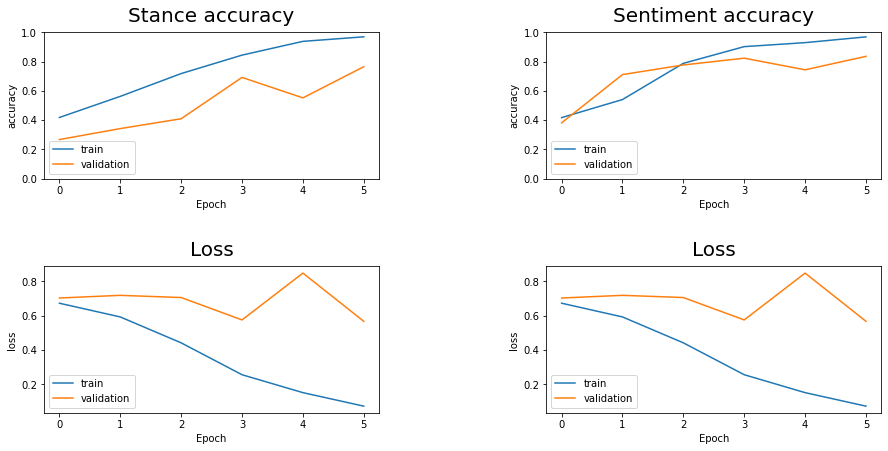

Model evaluation 

Stance classification for target: abortion

              precision    recall  f1-score   support

     Against       0.84      0.63      0.72       189
 Non-Against       0.49      0.75      0.59        91

    accuracy                           0.67       280
   macro avg       0.67      0.69      0.66       280
weighted avg       0.73      0.67      0.68       280



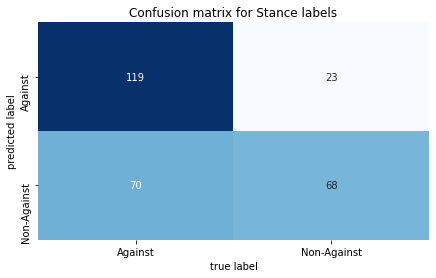

*******************************************************

Sentiment classification for target: abortion

              precision    recall  f1-score   support

    Negative       0.92      0.81      0.86       202
Non-negative       0.62      0.81      0.70        78

    accuracy                           0.81       280
   macro avg       0.77      0.81      0.78       280
weighted avg       0.83      0.81      0.82       280



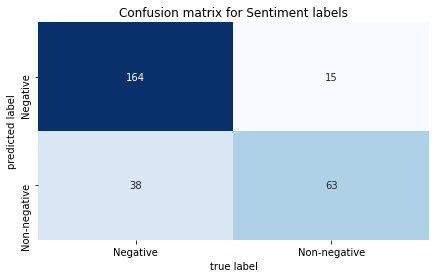

Training for target: feminism 
Epoch 1/6
--------------------
Training: loss: 0.6404284031854736 accuracy: Stance 0.39388738629536707 Sentiment 0.4301492614662644
Validation: loss: 0.6074343877179282 accuracy: Stance 0.3415600780752791 Sentiment 0.43548874747031424 

Validation loss decreased (inf --> 0.607).  Saving model ...

Epoch 2/6
--------------------
Training: loss: 0.5824524503615167 accuracy: Stance 0.5077449640717275 Sentiment 0.5327318116501415
Validation: loss: 0.5991694842066083 accuracy: Stance 0.58207898544033 Sentiment 0.6509263099179065 

Validation loss decreased (0.607 --> 0.599).  Saving model ...

Epoch 3/6
--------------------
Training: loss: 0.4538593776524067 accuracy: Stance 0.6608881982978992 Sentiment 0.7725831329466353
Validation: loss: 0.5739559871809823 accuracy: Stance 0.6378324056895485 Sentiment 0.7104621158808351 

Validation loss decreased (0.599 --> 0.574).  Saving model ...

Epoch 4/6
--------------------
Training: loss: 0.3236037728687127 accuracy

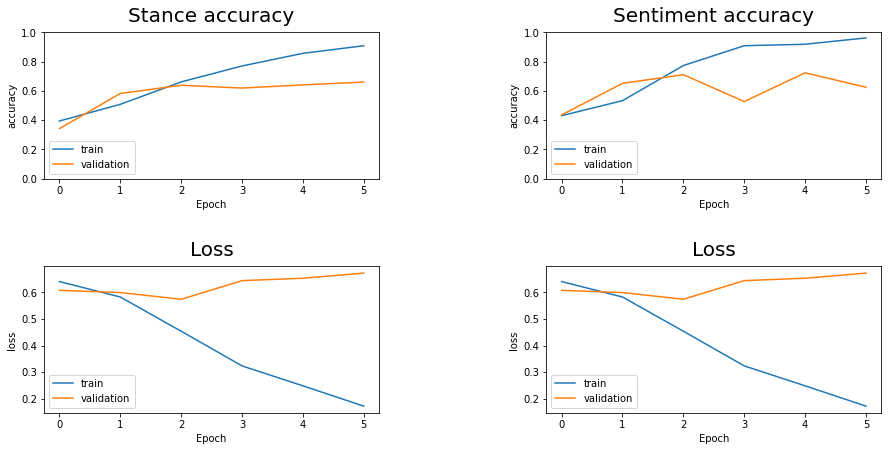

Model evaluation 

Stance classification for target: feminism

              precision    recall  f1-score   support

     Against       0.92      0.42      0.57       183
 Non-Against       0.47      0.93      0.62       102

    accuracy                           0.60       285
   macro avg       0.69      0.67      0.60       285
weighted avg       0.76      0.60      0.59       285



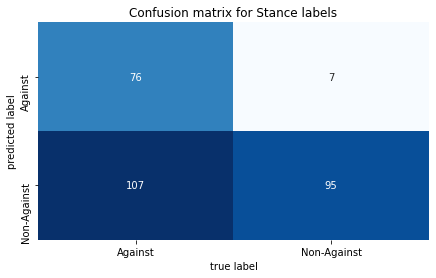

*******************************************************

Sentiment classification for target: feminism

              precision    recall  f1-score   support

    Negative       0.84      0.94      0.89       217
Non-negative       0.69      0.43      0.53        68

    accuracy                           0.82       285
   macro avg       0.76      0.68      0.71       285
weighted avg       0.80      0.82      0.80       285



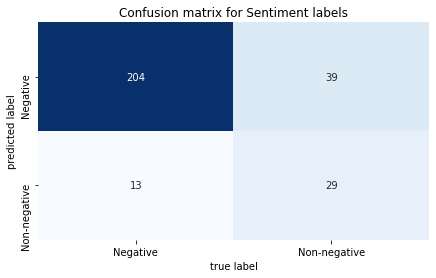

Training for target: hillary 
Epoch 1/6
--------------------
Training: loss: 0.6644803120030297 accuracy: Stance 0.4211637879285124 Sentiment 0.42899471206562767
Validation: loss: 0.6166665926575661 accuracy: Stance 0.5933695052461038 Sentiment 0.683191466241669 

Validation loss decreased (inf --> 0.617).  Saving model ...

Epoch 2/6
--------------------
Training: loss: 0.570271243651708 accuracy: Stance 0.6037177247288524 Sentiment 0.7240260740201252
Validation: loss: 0.5413609147071838 accuracy: Stance 0.7112111813568941 Sentiment 0.7659443819854036 

Validation loss decreased (0.617 --> 0.541).  Saving model ...

Epoch 3/6
--------------------
Training: loss: 0.4515490076608128 accuracy: Stance 0.700572472901914 Sentiment 0.8631267922811201
Validation: loss: 0.5080217383801937 accuracy: Stance 0.7046632970516569 Sentiment 0.7775866290572173 

Validation loss decreased (0.541 --> 0.508).  Saving model ...

Epoch 4/6
--------------------
Training: loss: 0.3298565170003308 accuracy: S

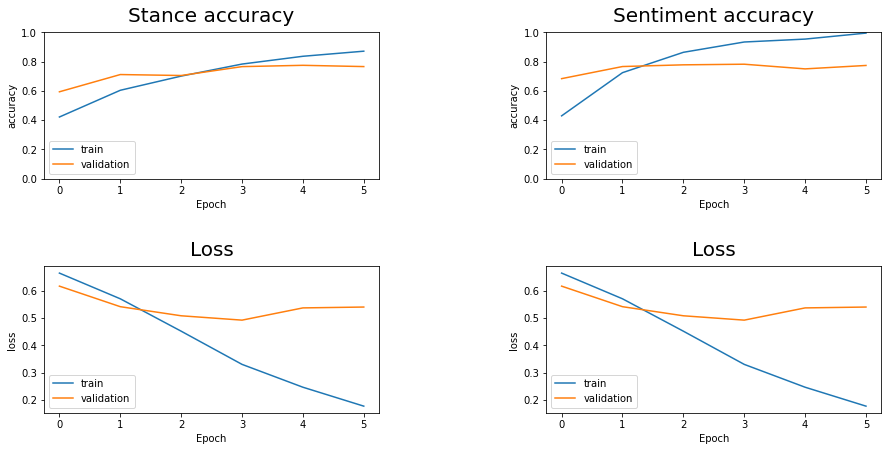

Model evaluation 

Stance classification for target: hillary

              precision    recall  f1-score   support

     Against       0.74      0.76      0.75       172
 Non-Against       0.65      0.63      0.64       123

    accuracy                           0.71       295
   macro avg       0.70      0.69      0.70       295
weighted avg       0.70      0.71      0.70       295



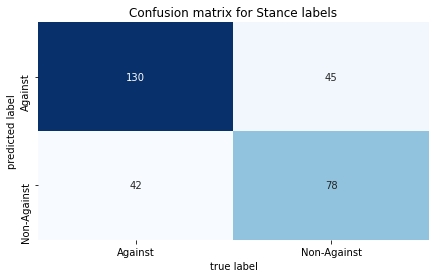

*******************************************************

Sentiment classification for target: hillary

              precision    recall  f1-score   support

    Negative       0.86      0.93      0.89       207
Non-negative       0.79      0.65      0.71        88

    accuracy                           0.84       295
   macro avg       0.83      0.79      0.80       295
weighted avg       0.84      0.84      0.84       295



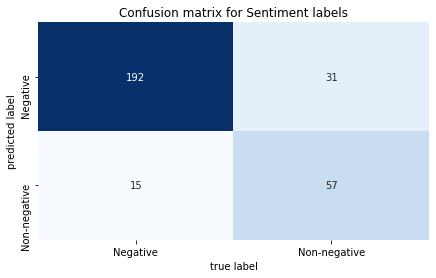

Training for target: atheism 
Epoch 1/6
--------------------
Training: loss: 0.6757949846131461 accuracy: Stance 0.4614532258095561 Sentiment 0.43933829347752085
Validation: loss: 0.6191640138626099 accuracy: Stance 0.5793917193917195 Sentiment 0.6760966810966811 

Validation loss decreased (inf --> 0.619).  Saving model ...

Epoch 2/6
--------------------
Training: loss: 0.5220689039145198 accuracy: Stance 0.7088634218567348 Sentiment 0.7201359087825494
Validation: loss: 0.4546648681163788 accuracy: Stance 0.7026233766233766 Sentiment 0.7810695970695971 

Validation loss decreased (0.619 --> 0.455).  Saving model ...

Epoch 3/6
--------------------
Training: loss: 0.37669263247932705 accuracy: Stance 0.8132991190854201 Sentiment 0.8078649687086222
Validation: loss: 0.410366553068161 accuracy: Stance 0.7434632034632034 Sentiment 0.8006706819750298 

Validation loss decreased (0.455 --> 0.410).  Saving model ...

Epoch 4/6
--------------------
Training: loss: 0.31799120189888136 accurac

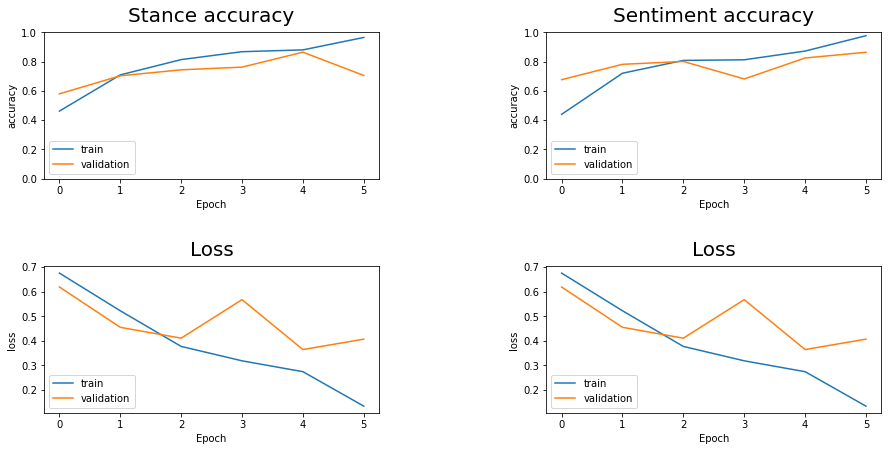

Model evaluation 

Stance classification for target: atheism

              precision    recall  f1-score   support

     Against       0.97      0.69      0.81       160
 Non-Against       0.53      0.93      0.68        60

    accuracy                           0.76       220
   macro avg       0.75      0.81      0.74       220
weighted avg       0.85      0.76      0.77       220



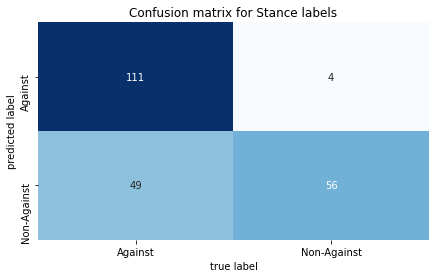

*******************************************************

Sentiment classification for target: atheism

              precision    recall  f1-score   support

Non-positive       0.77      0.82      0.80        90
    Positive       0.87      0.83      0.85       130

    accuracy                           0.83       220
   macro avg       0.82      0.83      0.82       220
weighted avg       0.83      0.83      0.83       220



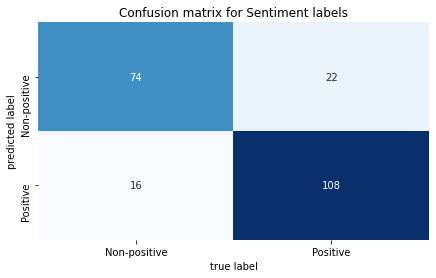

Training for target: climate 
Epoch 1/6
--------------------
Training: loss: 0.694407425143502 accuracy: Stance 0.4714365708488862 Sentiment 0.45642626543484965
Validation: loss: 0.684538722038269 accuracy: Stance 0.5007215007215007 Sentiment 0.4790206284943127 

Validation loss decreased (inf --> 0.685).  Saving model ...

Epoch 2/6
--------------------
Training: loss: 0.6715661693703044 accuracy: Stance 0.5672010756069543 Sentiment 0.5554650269706743
Validation: loss: 0.6370707154273987 accuracy: Stance 0.6481859356001232 Sentiment 0.5697832233873423 

Validation loss decreased (0.685 --> 0.637).  Saving model ...

Epoch 3/6
--------------------
Training: loss: 0.5792976970022375 accuracy: Stance 0.775846293057101 Sentiment 0.5513263817807437
Validation: loss: 0.5496485233306885 accuracy: Stance 0.7910364145658263 Sentiment 0.6065118710427635 

Validation loss decreased (0.637 --> 0.550).  Saving model ...

Epoch 4/6
--------------------
Training: loss: 0.46330488269979303 accuracy: 

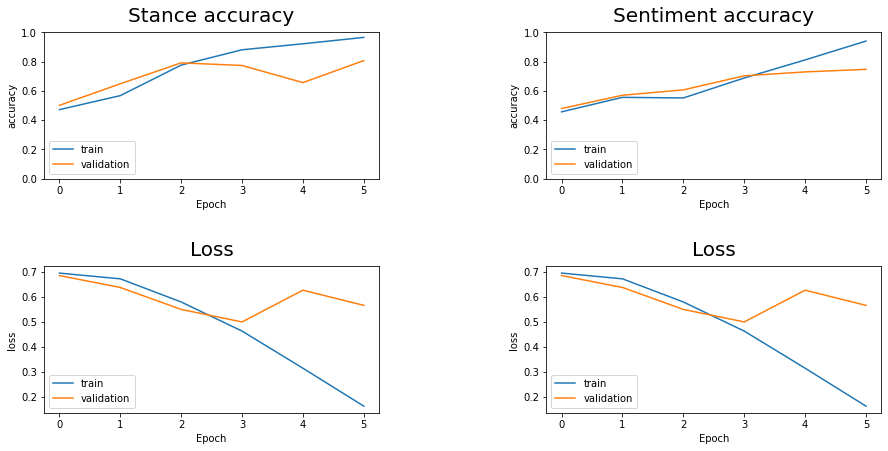

Model evaluation 

Stance classification for target: climate

              precision    recall  f1-score   support

   Non-Favor       0.79      0.50      0.61        46
       Favor       0.84      0.95      0.89       123

    accuracy                           0.83       169
   macro avg       0.81      0.73      0.75       169
weighted avg       0.82      0.83      0.81       169



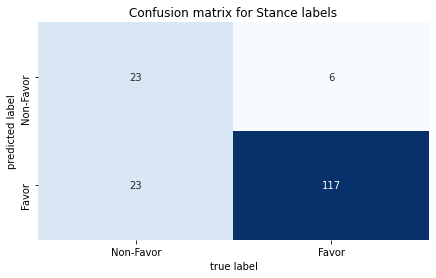

*******************************************************

Sentiment classification for target: climate

              precision    recall  f1-score   support

    Negative       0.82      0.77      0.79        87
Non-negative       0.77      0.82      0.79        82

    accuracy                           0.79       169
   macro avg       0.79      0.79      0.79       169
weighted avg       0.79      0.79      0.79       169



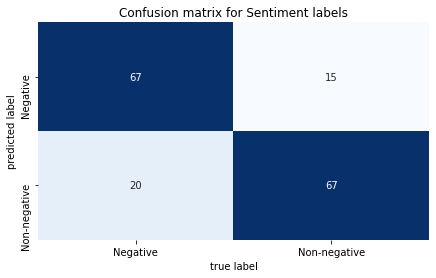



Overall results:

                        abortion  feminism  hillary  atheism  climate
0  Stance f1-score      0.66      0.60      0.7      0.74     0.75   
1  Sentiment f1-score   0.78      0.71      0.8      0.82     0.79   
2  Training time (min)  11.35     11.19     11.7     8.98     6.97   


In [451]:
EPOCHS = 6

MAX_LEN = 50 
BATCH_SIZE = 16


overall_results = {}


targets = ['abortion', 'feminism','hillary','atheism', 'climate']
#targets = ['atheism', 'feminism']

for tar in targets:

    early_stopping = EarlyStopping(patience=5, verbose=True)
    
    
    train_data_loader, val_data_loader, test_data_loader = load_target_data(tar)
    
    model = BertClassifier(freeze_bert = False).to(device)
    
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

    loss_fn = nn.BCEWithLogitsLoss().to(device)
    

    history = defaultdict(list)
    
    print('*' * 65)
    print(f'Training for target: {tar} ')
    st = time.time()
    
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 20)

        train_acc_stc, train_acc_sent, train_loss = train_epoch(model, train_data_loader,
                                                                loss_fn, optimizer, device, scheduler)
        
        print(f'Training: loss: {train_loss} accuracy: Stance {train_acc_stc} Sentiment {train_acc_sent}')

        val_acc_stc, val_acc_sent, val_loss = eval_model(model, val_data_loader, loss_fn, device,
                                                    checkpoint_path, best_model_path)

        print(f'Validation: loss: {val_loss} accuracy: Stance {val_acc_stc} Sentiment {val_acc_sent} \n')
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print('Early stopping\n')
            break

        history['train_acc_stc'].append(train_acc_stc)
        history['train_acc_sent'].append(train_acc_sent)
        history['train_loss'].append(train_loss)
        history['val_acc_stc'].append(val_acc_stc)
        history['val_acc_sent'].append(val_acc_sent)
        history['val_loss'].append(val_loss)
        
    print(f'\nModel training history for {tar} target')
    
    tr_time = round((time.time() - st)/60,2)
    
    print(f'\nTraining complete in {tr_time} minutes ')
    
        
    f, axes = plt.subplots(2, 2, sharey=False, figsize=(15, 7))
    
    plt.subplots_adjust(wspace=0.5, hspace=0.6)

    axes[0,0].plot(history['train_acc_stc'], label='train')
    axes[0,0].plot(history['val_acc_stc'], label='validation')
    axes[0,0].set_ylabel('accuracy')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].legend(loc=3, fontsize=10)
    axes[0,0].set_ylim([0, 1])
    axes[0,0].set_title("Stance accuracy", fontsize="20",  y=1.03)
    
    axes[0,1].plot(history['train_acc_sent'], label='train')
    axes[0,1].plot(history['val_acc_sent'], label='validation')
    axes[0,1].set_ylabel('accuracy')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].legend(loc=3, fontsize=10)
    axes[0,1].set_ylim([0, 1])
    axes[0,1].set_title("Sentiment accuracy", fontsize="20",  y=1.03)
    

    axes[1,0].plot(history['train_loss'], label='train')
    axes[1,0].plot(history['val_loss'], label='validation')
    axes[1,0].set_ylabel('loss')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].legend(loc=3, fontsize=10)
    axes[1,0].set_title("Loss", fontsize="20",  y=1.03)
    
    axes[1,1].plot(history['train_loss'], label='train')
    axes[1,1].plot(history['val_loss'], label='validation')
    axes[1,1].set_ylabel('loss')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].legend(loc=3, fontsize=10)
    axes[1,1].set_title("Loss", fontsize="20",  y=1.03)

    plt.show()
    
    
    
    
    
    #model evaluation on the test set
    
    model.load_state_dict(torch.load(f'best_model_{tar}.pt'))
    text, y_pred_stc, y_test_stc,y_pred_sent, y_test_sent = get_predictions(model, test_data_loader)
    
    
    print('Model evaluation \n')
    
    print(f'Stance classification for target: {tar}\n')

    print(classification_report(y_test_stc, y_pred_stc, target_names = set_index(tar)[0]))
    report_stc = classification_report(y_test_stc, y_pred_stc, output_dict=True)
    f1_score_stc = report_stc.get('macro avg')['f1-score']
    con = confusion_matrix(y_test_stc, y_pred_stc)
    plt.figure(figsize=(7,4))
    ax = sns.heatmap(con.T, square=False, annot=True, fmt='d', cbar=False,
                       xticklabels = set_index(tar)[0], 
                       yticklabels = set_index(tar)[0],
                       cmap="Blues")
    
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title('Confusion matrix for Stance labels')
    plt.show()
    
    
    print('*' * 55)
    print(f'\nSentiment classification for target: {tar}\n')

    print(classification_report(y_test_sent, y_pred_sent, target_names = set_index(tar)[1]))
    report_sent = classification_report(y_test_sent, y_pred_sent, output_dict=True)
    f1_score_sent = report_sent.get('macro avg')['f1-score']
    con = confusion_matrix(y_test_sent, y_pred_sent)
    plt.figure(figsize=(7,4))
    ax = sns.heatmap(con.T, square=False, annot=True, fmt='d', cbar=False,
                       xticklabels = set_index(tar)[1], 
                       yticklabels = set_index(tar)[1],
                       cmap="Blues")
    
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title('Confusion matrix for Sentiment labels')
    plt.show()
    
    
    dic = {'':['Stance f1-score', 'Sentiment f1-score', 'Training time (min)'],
           f'{tar}':[round(f1_score_stc,2), round(f1_score_sent,2), tr_time]
          }

    overall_results.update(dic)

print('\n\nOverall results:\n')
df = pd.DataFrame(overall_results)
print(df)
        

# Model evaluation

To reproduce model results, upload the best_model

In [ ]:
EPOCHS = 6

MAX_LEN = 50 
BATCH_SIZE = 16


overall_results = {}


targets = ['abortion', 'feminism','hillary','atheism', 'climate']


for tar in targets:

    train_data_loader, val_data_loader, test_data_loader = load_target_data(tar)
    
    
    model.load_state_dict(torch.load(f'best_model_{tar}.pt'))
    text, y_pred_stc, y_test_stc,y_pred_sent, y_test_sent = get_predictions(model, test_data_loader)
    
    
    print('Model evaluation \n')
    
    print(f'Stance classification for target: {tar}\n')

    print(classification_report(y_test_stc, y_pred_stc, target_names = set_index(tar)[0]))
    report_stc = classification_report(y_test_stc, y_pred_stc, output_dict=True)
    f1_score_stc = report_stc.get('macro avg')['f1-score']
    con = confusion_matrix(y_test_stc, y_pred_stc)
    plt.figure(figsize=(7,4))
    ax = sns.heatmap(con.T, square=False, annot=True, fmt='d', cbar=False,
                       xticklabels = set_index(tar)[0], 
                       yticklabels = set_index(tar)[0],
                       cmap="Blues")
    
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title('Confusion matrix for Stance labels')
    plt.show()
    
    
    print('*' * 55)
    print(f'\nSentiment classification for target: {tar}\n')

    print(classification_report(y_test_sent, y_pred_sent, target_names = set_index(tar)[1]))
    report_sent = classification_report(y_test_sent, y_pred_sent, output_dict=True)
    f1_score_sent = report_sent.get('macro avg')['f1-score']
    con = confusion_matrix(y_test_sent, y_pred_sent)
    plt.figure(figsize=(7,4))
    ax = sns.heatmap(con.T, square=False, annot=True, fmt='d', cbar=False,
                       xticklabels = set_index(tar)[1], 
                       yticklabels = set_index(tar)[1],
                       cmap="Blues")
    
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title('Confusion matrix for Sentiment labels')
    plt.show()
    
    
    dic = {'':['Stance f1-score', 'Sentiment f1-score', 'Training time (min)'],
           f'{tar}':[round(f1_score_stc,2), round(f1_score_sent,2), tr_time]
          }

    overall_results.update(dic)

print('\n\nOverall results:\n')
df = pd.DataFrame(overall_results)
print(df)

In [452]:
df

,,abortion,feminism,hillary,atheism,climate
0,Stance f1-score,0.66,0.60,0.7,0.74,0.75
1,Sentiment f1-score,0.78,0.71,0.8,0.82,0.79
2,Training time (min),11.35,11.19,11.7,8.98,6.97


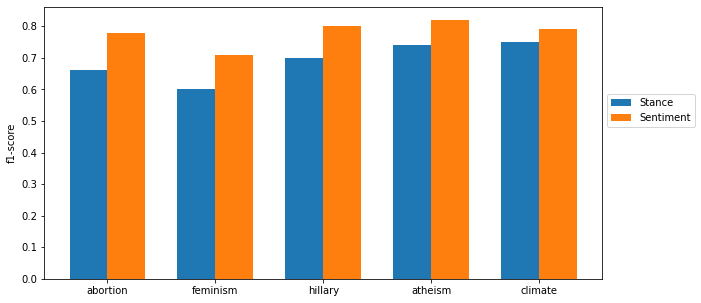

In [454]:
N = 5
ind = np.arange(N) 
width = 0.35  
plt.figure(figsize=(10,5))
plt.bar(ind, df.iloc[0,1:], width, label='Stance')
plt.bar(ind + width, df.iloc[1,1:], width, label='Sentiment')

plt.ylabel('f1-score')
#plt.title('Model performance on the test dataset')

plt.xticks(ind + width / 2, t1)
plt.legend(loc='best', bbox_to_anchor=(1, 0.7))
plt.show()

# Error analysis

In [ ]:
dic_stc = {}
dic_sent = {}

for tar in targets:
    model.load_state_dict(torch.load(f'best_model_{tar}.pt'))
    _, _, test_data_loader = load_target_data(tar)
    text1, y_pred_stc1, y_test_stc1,y_pred_sent1, y_test_sent1 = get_predictions(model, test_data_loader)
    
    d_stc = {'Tweet_{}'.format(tar):text1,
             'Pred_{}'.format(tar):y_pred_stc1,
             'True_{}'.format(tar):y_test_stc1 }
    dic_stc.update(d_stc)
    
    d_sent = {'Tweet_{}'.format(tar):text1,
              'Pred_{}'.format(tar):y_pred_sent1,
              'True_{}'.format(tar):y_test_sent1 }
    dic_sent.update(d_sent)

In [ ]:
dic_stc.keys() 

In [ ]:
pd.set_option('display.max_colwidth', 0)

In [ ]:
targ = { 1:'atheism',
         2:'climate',
        3:'feminism',
         4:'hillary',
       5:'abortion'}

In [ ]:
num=3
wp = pd.DataFrame(dic_stc, columns=[f'Tweet_{targ.get(num)}', f'Pred_{targ.get(num)}', f'True_{targ.get(num)}'])
lp = wp[wp[f'Pred_{targ.get(num)}']!=wp[f'True_{targ.get(num)}']]
lp.to_csv('lp.csv',index=False)

In [ ]:
num=3
wp = pd.DataFrame(dic_sent, columns=[f'Tweet_{targ.get(num)}', f'Pred_{targ.get(num)}', f'True_{targ.get(num)}'])
wp[wp[f'Pred_{targ.get(num)}']!=wp[f'True_{targ.get(num)}']]

